In [1]:
!python -m pip install numpy
!python -m pip install pandas
!python -m pip install matplotlib
!python -m pip install scipy
!python -m pip install sklearn

    100% |████████████████████████████████| 17.3MB 94kB/s  eta 0:00:01
    100% |████████████████████████████████| 10.1MB 156kB/s ta 0:00:011
    100% |████████████████████████████████| 512kB 3.5MB/s eta 0:00:01
    100% |████████████████████████████████| 13.0MB 126kB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 6.4MB/s eta 0:00:01
    100% |████████████████████████████████| 952kB 1.8MB/s eta 0:00:01
    100% |████████████████████████████████| 24.8MB 68kB/s  eta 0:00:01
    100% |████████████████████████████████| 5.4MB 276kB/s ta 0:00:011
  Stored in directory: /home/jovyan/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder
from scipy.optimize import minimize

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [4]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]

    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

In [5]:
def cost(h, y, learning_rate):
    m = y.shape[0]

    # initializations
    J = 0

    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i, :], np.log(h[i, :]))
        second_term = np.multiply((1 - y[i, :]), np.log(1 - h[i, :]))
        J += np.sum(first_term - second_term)

    J = J / m

    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)))

    return J

In [6]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [7]:
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    J = cost(h, y, learning_rate)
    
    # Actually perform back propagation
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)

    # perform backpropagation
    for t in range(m):
        a1t = a1[t, :]  # (1, 401)
        z2t = z2[t, :]  # (1, 25)
        a2t = a2[t, :]  # (1, 26)
        ht = h[t, :]  # (1, 10)
        yt = y[t, :]  # (1, 10)

        d3t = ht - yt  # (1, 10)

        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)

        delta1 = delta1 + (d2t[:, 1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t

    delta1 = delta1 / m
    delta2 = delta2 / m

    # add the gradient regularization term
    delta1[:, 1:] = delta1[:, 1:] + (theta1[:, 1:] * learning_rate) / m
    delta2[:, 1:] = delta2[:, 1:] + (theta2[:, 1:] * learning_rate) / m

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))

    return J, grad

In [8]:
# load data
data = loadmat('ex4data1.mat')

X = data['X']
y = data['y']
print(X.shape, y.shape)

(5000, 400) (5000, 1)


In [9]:
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
print(y_onehot.shape)

(5000, 10)


/srv/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


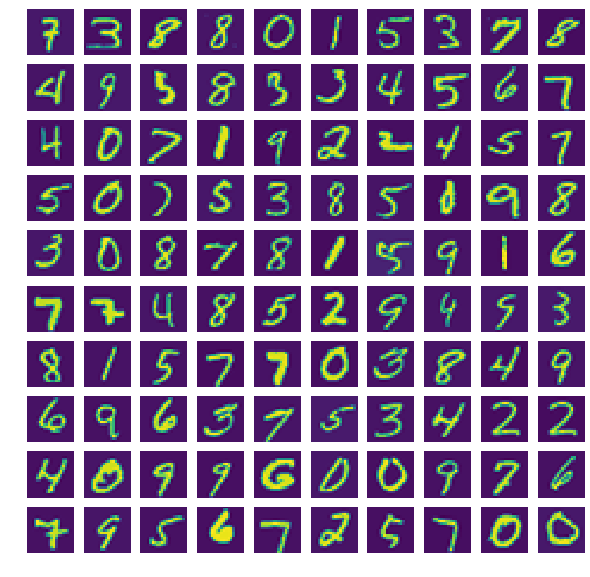

In [10]:
# visualizing the data
_, axarr = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        axarr[i, j].imshow(X[np.random.randint(X.shape[0])].
                           reshape((20, 20), order='F'))
        axarr[i, j].axis('off')

In [22]:
# initial setup
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1

In [23]:
# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25
print('params = ', params)
print(params.shape)

params =  [ 0.09438108  0.11937153 -0.00707933 ...  0.07858308  0.06531728
  0.10016425]
(10285,)


In [24]:
m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

In [28]:
# unravel the parameter array into parameter matrices for each layer
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

print('theta1 = \n', theta1)
print('shape = ', theta1.shape)
print()
print('theta2 = \n', theta2)
print('shape = ', theta2.shape)

theta1 = 
 [[ 0.09438108  0.11937153 -0.00707933 ... -0.08771636 -0.06032015
   0.0055536 ]
 [ 0.03453799 -0.08960896 -0.06733081 ... -0.08417065  0.11798154
   0.01300099]
 [ 0.02522091 -0.03362049 -0.09913598 ... -0.02177418 -0.05153128
  -0.08519415]
 ...
 [ 0.1109334   0.11352858 -0.02037555 ... -0.00968042  0.01762951
   0.01140859]
 [-0.03425215 -0.03652524 -0.00369569 ... -0.02551348 -0.04268198
  -0.07429168]
 [-0.02379384  0.10134456  0.12299775 ... -0.05678306 -0.06666899
  -0.0823205 ]]
shape =  (25, 401)

theta2 = 
 [[ 0.0859904  -0.02016088 -0.07374     0.01395348  0.0636325  -0.10973944
   0.02096499  0.0897989   0.1239781   0.07592049  0.04105159 -0.07703145
   0.10996161  0.0475801   0.05104292 -0.03907533  0.09345907 -0.08675144
  -0.09005135 -0.00179914  0.12464353  0.10416427  0.05104092  0.10311117
  -0.03162245  0.09905569]
 [-0.08226204  0.08410708 -0.09731746 -0.11496153 -0.1130079   0.02060117
   0.03826034 -0.07794448 -0.03571513 -0.10152161  0.03009945  0.0246

In [29]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
print(a1.shape, z2.shape, a2.shape, z3.shape, h.shape)

(5000, 401) (5000, 25) (5000, 26) (5000, 10) (5000, 10)


In [30]:
print(cost(h, y, learning_rate))

19.23528016748066


In [31]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
print(J, grad.shape)

7.327011197498186 (10285,)


In [ ]:
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate),
                method='TNC', jac=True, options={'maxiter': 50})
print(fmin)

In [ ]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)

correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy = {0}%'.format(accuracy * 100))